In [6]:
# =========================
# 1. IMPORT THƯ VIỆN
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam



In [7]:
# =========================
# 2. ĐỌC DỮ LIỆU
# =========================
print("\n==> Đọc dữ liệu từ file wti_prices.csv ...")
df = pd.read_csv('wti_prices.csv')
print("5 dòng đầu:")
print(df.head())


==> Đọc dữ liệu từ file wti_prices.csv ...
5 dòng đầu:
         date   open   high    low  close  volume  average
0  2024-04-04  75.90  76.71  75.44  76.46  4467.0   76.149
1  2024-04-05  76.54  76.91  76.23  76.41  3429.0   76.552
2  2024-04-08  76.57  76.74  75.54  76.18  2276.0   76.070
3  2024-04-09  76.42  76.52  75.48  75.63  1811.0   75.900
4  2024-04-10  76.01  76.48  75.45  76.27  3500.0   76.077


In [8]:
# =========================
# 3. TIỀN XỬ LÝ
# =========================
print("\n==> Kiểm tra trùng lặp...")
duplicates = df.duplicated().sum()
print("Số dòng trùng lặp:", duplicates)

# Chuyển date sang datetime
df['date'] = pd.to_datetime(df['date'])

# Sắp xếp theo ngày
df = df.sort_values('date')

# XÓA CÁC DÒNG TRÙNG NGÀY (giữ dòng cuối cùng trong ngày)
df = df.drop_duplicates(subset='date', keep='last')

# Đặt lại index
df = df.set_index('date')

# Resample daily
df = df.resample('D').ffill()



==> Kiểm tra trùng lặp...
Số dòng trùng lặp: 3



========== PHÂN TÍCH DỮ LIỆU THĂM DÒ (EDA) ==========

==> Thông tin tổng quan dữ liệu:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054 entries, 2016-11-23 to 2025-04-03
Freq: D
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     3054 non-null   float64
 1   high     3054 non-null   float64
 2   low      3054 non-null   float64
 3   close    3054 non-null   float64
 4   volume   3054 non-null   float64
 5   average  3054 non-null   float64
dtypes: float64(6)
memory usage: 167.0 KB
None

==> Thống kê mô tả giá Close:
count    3054.000000
mean       59.561041
std         9.650958
min        40.390000
25%        52.272500
50%        55.700000
75%        69.280000
max        79.010000
Name: close, dtype: float64

==> Kiểm tra giá trị thiếu:
open       0
high       0
low        0
close      0
volume     0
average    0
dtype: int64

==> Kiểm tra outlier giá Close (IQR method):
Số lượng outlier: 0

==> Vẽ biểu đồ

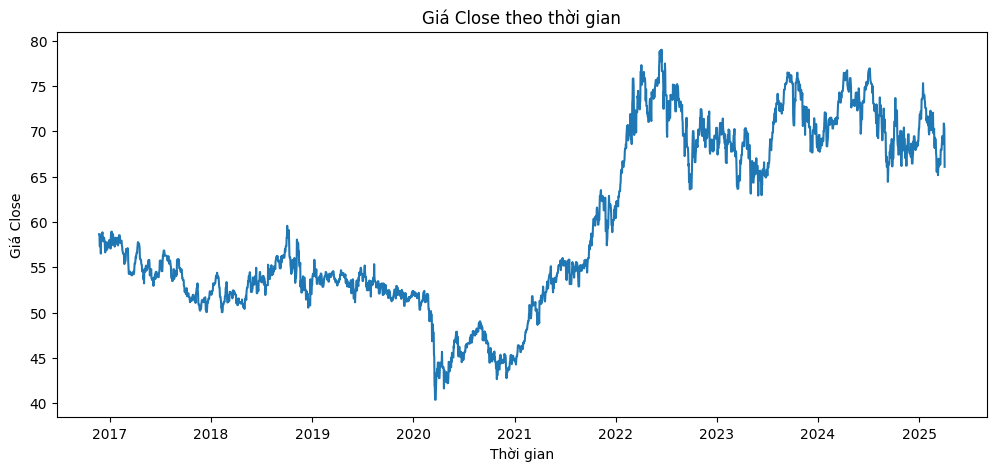


==> Vẽ biểu đồ phân phối giá Close...


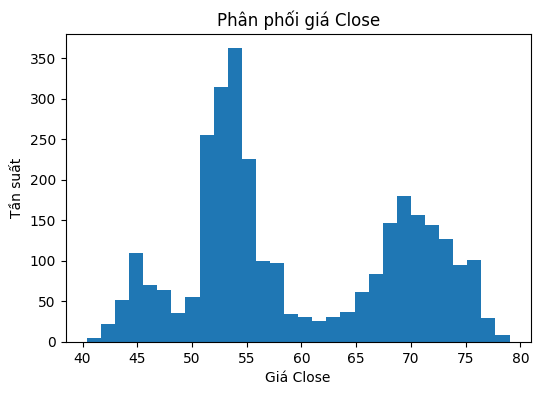


========== KẾT THÚC EDA ==========


In [9]:
# =========================
# 4. PHÂN TÍCH DỮ LIỆU THĂM DÒ (EDA)
# =========================
print("\n========== PHÂN TÍCH DỮ LIỆU THĂM DÒ (EDA) ==========")

# 4.1. Thông tin tổng quan dữ liệu
print("\n==> Thông tin tổng quan dữ liệu:")
print(df.info())

# 4.2. Thống kê mô tả cho cột close
print("\n==> Thống kê mô tả giá Close:")
print(df['close'].describe())

# 4.3. Kiểm tra giá trị thiếu
print("\n==> Kiểm tra giá trị thiếu:")
print(df.isnull().sum())

# 4.4. Kiểm tra outlier bằng IQR
print("\n==> Kiểm tra outlier giá Close (IQR method):")

Q1 = df['close'].quantile(0.25)
Q3 = df['close'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['close'] < lower_bound) | (df['close'] > upper_bound)]

print("Số lượng outlier:", outliers.shape[0])

# 4.5. Vẽ biểu đồ giá Close theo thời gian
print("\n==> Vẽ biểu đồ giá Close theo thời gian...")
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['close'])
plt.title("Giá Close theo thời gian")
plt.xlabel("Thời gian")
plt.ylabel("Giá Close")
plt.show()

# 4.6. Biểu đồ phân phối giá Close
print("\n==> Vẽ biểu đồ phân phối giá Close...")
plt.figure(figsize=(6, 4))
plt.hist(df['close'], bins=30)
plt.title("Phân phối giá Close")
plt.xlabel("Giá Close")
plt.ylabel("Tần suất")
plt.show()

print("\n========== KẾT THÚC EDA ==========")


In [10]:
# =========================
# 4. CHỌN CỘT CLOSE
# =========================
print("\n==> Chọn cột close để dự đoán...")
data = df[['close']].values
print("5 giá close đầu tiên:", data[:5])


==> Chọn cột close để dự đoán...
5 giá close đầu tiên: [[58.66]
 [58.66]
 [57.32]
 [57.32]
 [57.32]]


In [11]:
# =========================
# 5. CHUẨN HÓA & CHIA TRAIN-TEST
# =========================
print("\n==> Chuẩn hóa dữ liệu bằng MinMaxScaler...")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print("5 giá close sau khi chuẩn hóa:", scaled_data[:5])

print("\n==> Tạo tập train-test (80/20)...")
split = 0.8
train_size = int(len(scaled_data) * split)
print("Số lượng dữ liệu train:", train_size)
print("Số lượng dữ liệu test :", len(scaled_data) - train_size)


==> Chuẩn hóa dữ liệu bằng MinMaxScaler...
5 giá close sau khi chuẩn hóa: [[0.47307095]
 [0.47307095]
 [0.4383739 ]
 [0.4383739 ]
 [0.4383739 ]]

==> Tạo tập train-test (80/20)...
Số lượng dữ liệu train: 2443
Số lượng dữ liệu test : 611


In [12]:
# =========================
# 6. TẠO SEQUENCE CHO LSTM
# =========================
print("\n==> Tạo sequence lookback = 30 ngày...")
lookback = 30

X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

print("Kích thước X trước reshape:", X.shape)

X = X.reshape((X.shape[0], X.shape[1], 1))
print("Kích thước X sau reshape:", X.shape)

X_train = X[:train_size]
y_train = y[:train_size]
X_test  = X[train_size:]
y_test  = y[train_size:]


==> Tạo sequence lookback = 30 ngày...
Kích thước X trước reshape: (3024, 30)
Kích thước X sau reshape: (3024, 30, 1)


In [13]:
# =========================
# 7. XÂY DỰNG MÔ HÌNH LSTM
# =========================
print("\n==> Xây dựng mô hình LSTM...")

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer=Adam(0.001), loss='mse')
model.summary()


==> Xây dựng mô hình LSTM...


D:\anaconda\envs\cv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# =========================
# 8. HUẤN LUYỆN MÔ HÌNH
# =========================
print("\n==> Bắt đầu huấn luyện mô hình trong 50 epoch...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


==> Bắt đầu huấn luyện mô hình trong 50 epoch...
Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0267 - val_loss: 0.0018
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.2116e-04 - val_loss: 0.0015
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.7304e-04 - val_loss: 0.0018
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6593e-04 - val_loss: 0.0014
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7282e-04 - val_loss: 0.0012
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.8173e-04 - val_loss: 0.0014
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.4283e-04 - val_loss: 0.0013
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7529e-04 - val_loss: 9.7537e-04
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.9045e-04 - val

In [15]:
# =========================
# 9. DỰ ĐOÁN
# =========================
print("\n==> Dự đoán trên tập test...")
pred_scaled = model.predict(X_test)

print("==> Đảo chuẩn hóa kết quả...")
pred = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print("5 giá thực tế đầu tiên:", actual[:5].flatten())
print("5 giá dự đoán đầu tiên:", pred[:5].flatten())


==> Dự đoán trên tập test...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
==> Đảo chuẩn hóa kết quả...
5 giá thực tế đầu tiên: [74.6  74.6  74.6  74.6  75.12]
5 giá dự đoán đầu tiên: [73.773094 74.63539  74.46976  74.48228  74.51394 ]


In [17]:
# =========================
# 8.2. ĐÁNH GIÁ SAI SỐ
# =========================
print("\n========== 8.2. ĐÁNH GIÁ SAI SỐ ==========")

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Tính MAE
mae = mean_absolute_error(actual, pred)

# Tính MSE
mse = mean_squared_error(actual, pred)

# Tính RMSE
rmse = np.sqrt(mse)

# In kết quả
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MSE  (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")





========== 8.2. ĐÁNH GIÁ SAI SỐ ==========
MAE  (Mean Absolute Error): 0.5348
MSE  (Mean Squared Error): 0.6247
RMSE (Root Mean Squared Error): 0.7904



==> Vẽ biểu đồ Actual vs Predicted...


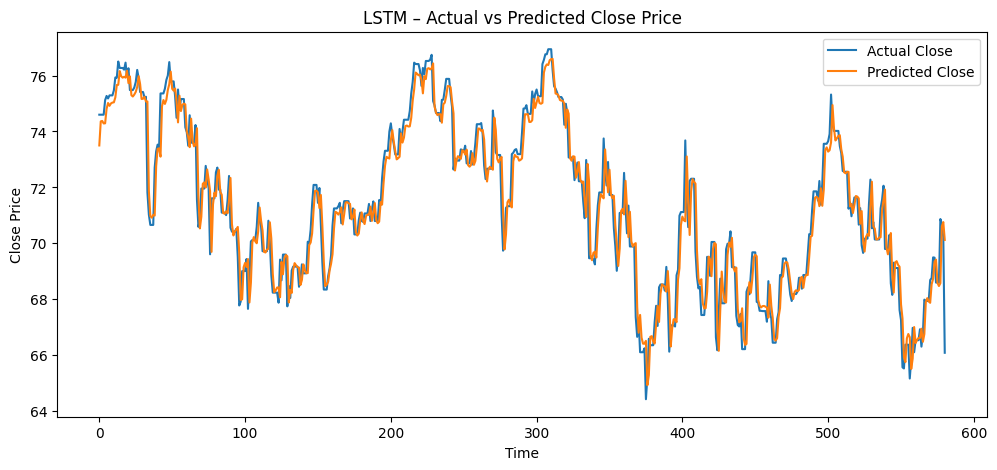


==> Hoàn thành!


In [19]:
# =========================
# 10. VẼ BIỂU ĐỒ
# =========================
print("\n==> Vẽ biểu đồ Actual vs Predicted...")
plt.figure(figsize=(12, 5))
plt.plot(actual, label="Actual Close")
plt.plot(pred, label="Predicted Close")
plt.title("LSTM – Actual vs Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

print("\n==> Hoàn thành!")
